## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Camera Calibration

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


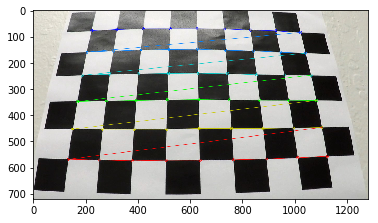

In [2]:
#reading in an image
calibration_example = mpimg.imread('camera_cal/calibration3.jpg')
chess_shape = (9,6)
#printing out some stats and plotting
calibration_gray = cv2.cvtColor(calibration_example, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(calibration_gray,(9,6))
cv2.drawChessboardCorners(calibration_example, (9,6), corners, ret)
print('This image is:', type(calibration_example), 'with dimensions:', calibration_example.shape)
plt.imshow(calibration_example)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
%pdb
import glob

def calibrate_camera(file_pattern, chess_shape):
    images = glob.glob(file_pattern)

    objpoints = []
    imgpoints = []

    objp = np.float32([(x,y,0) for x in range(chess_shape[1]) for y in range(chess_shape[0])])
    gray = None
    for image_file in images:
        image = mpimg.imread(image_file)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,chess_shape)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibrate_camera('camera_cal/calibration*.jpg', (9,6))

Automatic pdb calling has been turned ON


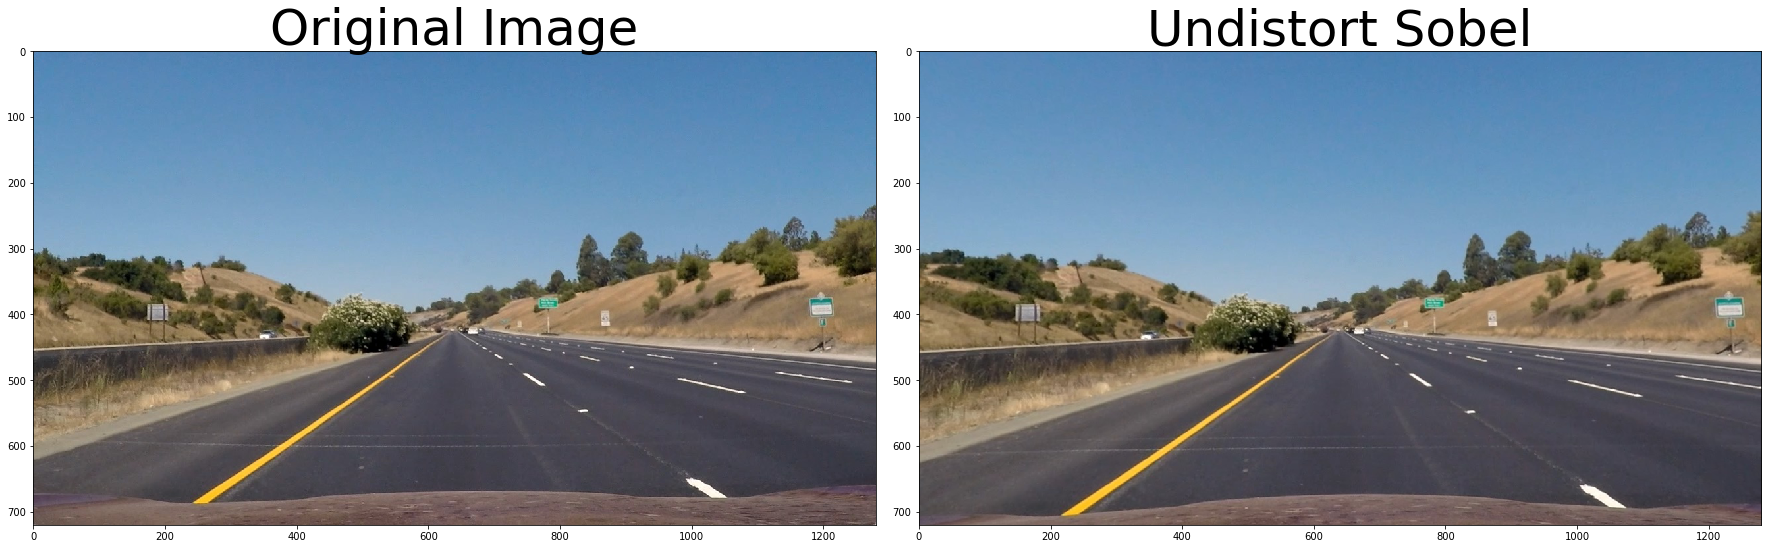

In [25]:
calibration_example = mpimg.imread('test_images/straight_lines1.jpg')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

f.tight_layout()

ax1.imshow(calibration_example)
ax1.set_title('Original Image', fontsize=50)

mpimg.imsave('test_images/straight_lines1_undist.png', cv2.undistort(calibration_example, mtx, dist, None, mtx))

ax2.imshow(mpimg.imread('test_images/straight_lines1_undist.png'))
ax2.set_title('Undistort Sobel', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Threshold Pixels

#### Sobel/Gradient filtering

In [5]:
"""Sobel Thresholding"""
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

def abs_sobel_thresh(single_channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Calculate the x and y gradients
    if orient == 'x':
        sobel = cv2.Sobel(single_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(single_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary =  np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(single_channel, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Calculate directional gradient
    # Calculate the x and y gradients
    sobel = [cv2.Sobel(single_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel),
             cv2.Sobel(single_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)]
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    mag_sobel = np.linalg.norm(sobel, axis=0)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary =  np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Apply threshold
    return mag_binary

def dir_threshold(single_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(single_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(single_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    scaled_sobel = np.uint8(255*absgraddir/np.max(absgraddir))
    dir_binary =  np.zeros_like(scaled_sobel)
    dir_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return dir_binary


# Apply each of the thresholding functions
def sobel_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,2]
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(40, 200))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(10, 150))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(80, 250))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(10*np.pi/180, 70*np.pi/180))
    # Run the function
    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255
    return sobel_combined

#### Color filtering

In [6]:
yellow_range= (np.array([19,100,100], dtype=np.uint8),
               np.array([25,255,255], dtype=np.uint8))
white_range = (np.array([0,             0,70 *255//100], dtype=np.uint8),
               np.array([179, 5 *255//100,         255], dtype=np.uint8))
white_range2= (np.array([  0,           0,90 *255//100], dtype=np.uint8),
               np.array([179,12 *255//100,         255], dtype=np.uint8))

def color_threshold(image):
    # Change to a better suited color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image, white is broken into to ranges, because of its behavior on HSV
    white_mask = cv2.bitwise_or(cv2.inRange(hsv, *white_range), cv2.inRange(hsv, *white_range2))
    yellow_mask = cv2.inRange(hsv, *yellow_range)
    # Add masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
#     # Dilate masks to include borders
#     mask = cv2.dilate(mask, None, iterations=5)  
#     mask = cv2.erode(mask, None, iterations=3)
    return mask


#### Combined filtering

In [7]:
def pixels_threshold(image):
    combined_threshold =  cv2.bitwise_or(color_threshold(image), sobel_threshold(image))
    return cv2.morphologyEx(combined_threshold, cv2.MORPH_OPEN, (ksize,ksize))

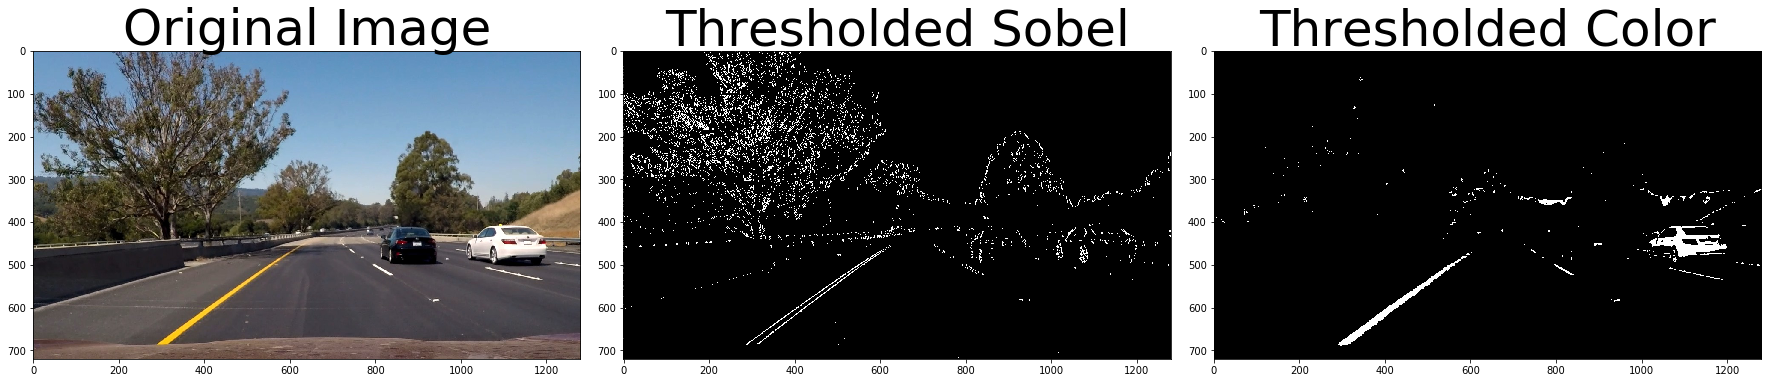

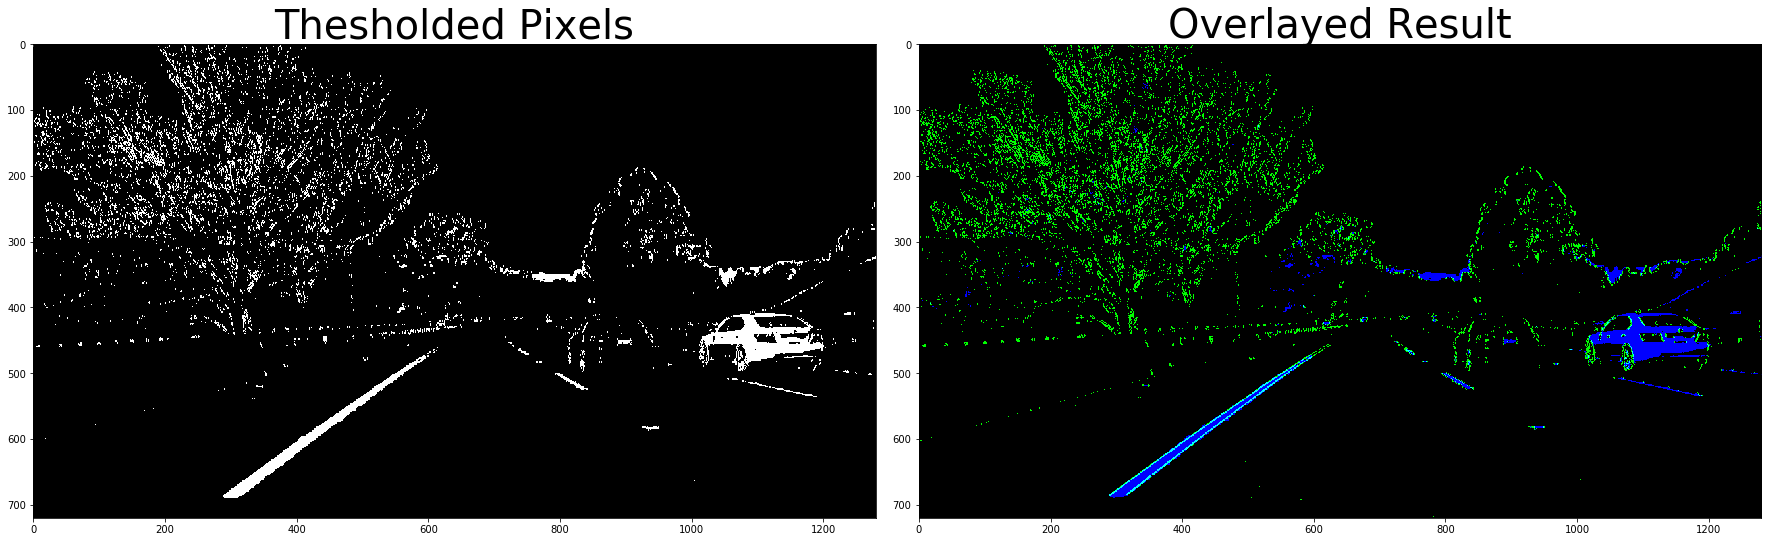

In [8]:
image = mpimg.imread('test_images/test6.jpg')
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
sobel_image = sobel_threshold(image)
ax2.imshow(sobel_image, cmap='gray')
ax2.set_title('Thresholded Sobel', fontsize=50)
color_image = color_threshold(image)
ax3.imshow(color_image, cmap='gray')
ax3.set_title('Thresholded Color', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Stack each channel
combined_binary = np.dstack(( np.zeros_like(sobel_image), sobel_image , color_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(pixels_threshold(image), cmap='gray')
ax1.set_title('Thesholded Pixels', fontsize=40)

ax2.imshow(combined_binary)
ax2.set_title('Overlayed Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transformation ("birds-eye view")

In [9]:
# src = np.float32((
#     (207, 720),
#     (624, 432),
#     (655, 432),
#     (1104, 720)
# ))
# dst = np.float32((
#     (207, 720),
#     (207, 0),
#     (1104, 0),
#     (1104, 720)
# ))
src = np.float32((
    (207, 720),
    (591, 453),
    (692, 453),
    (1104, 720)
))
dst = np.float32((
    (320, 720),
    (320, 0),
    (960, 0),
    (960, 720)
))
# dst = np.float32((
#     (207, 720),
#     (207, 0),
#     (1104, 0),
#     (1104, 720)
# ))
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def bird_eye(image):
    return cv2.warpPerspective(image, M, image.shape[1::-1])

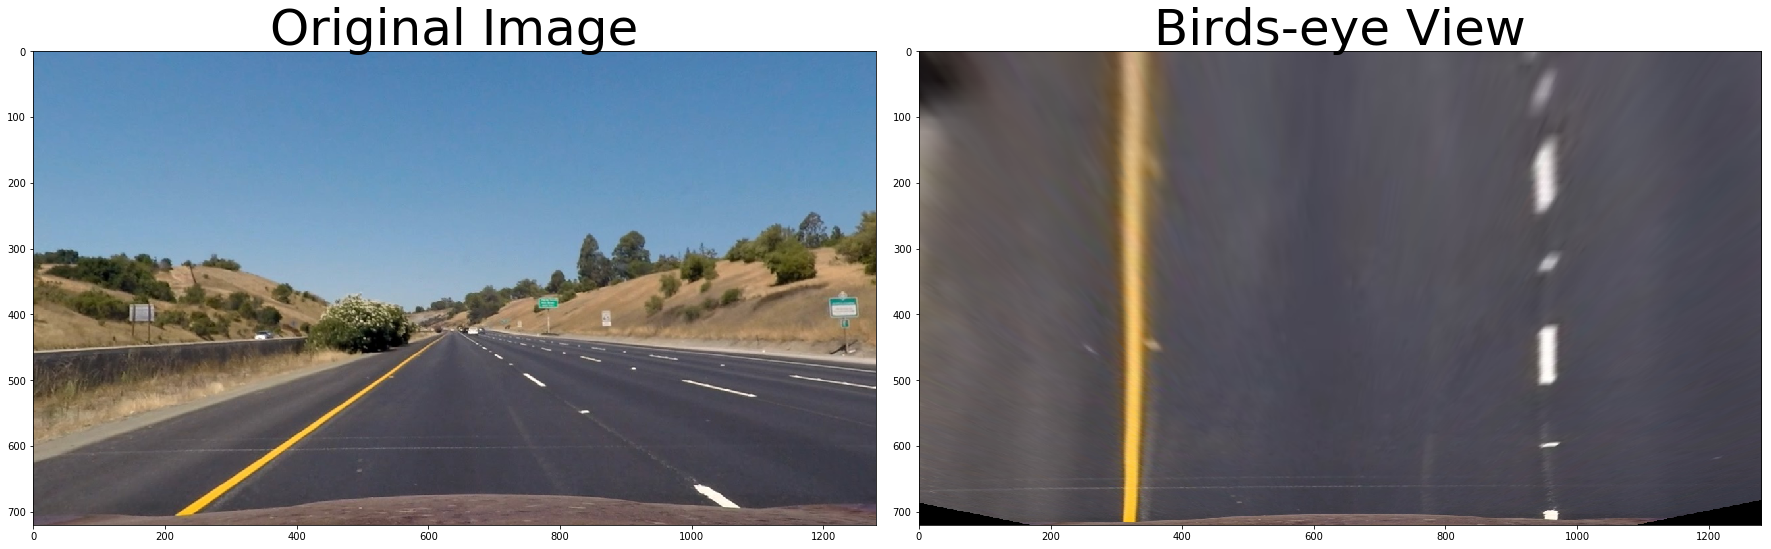

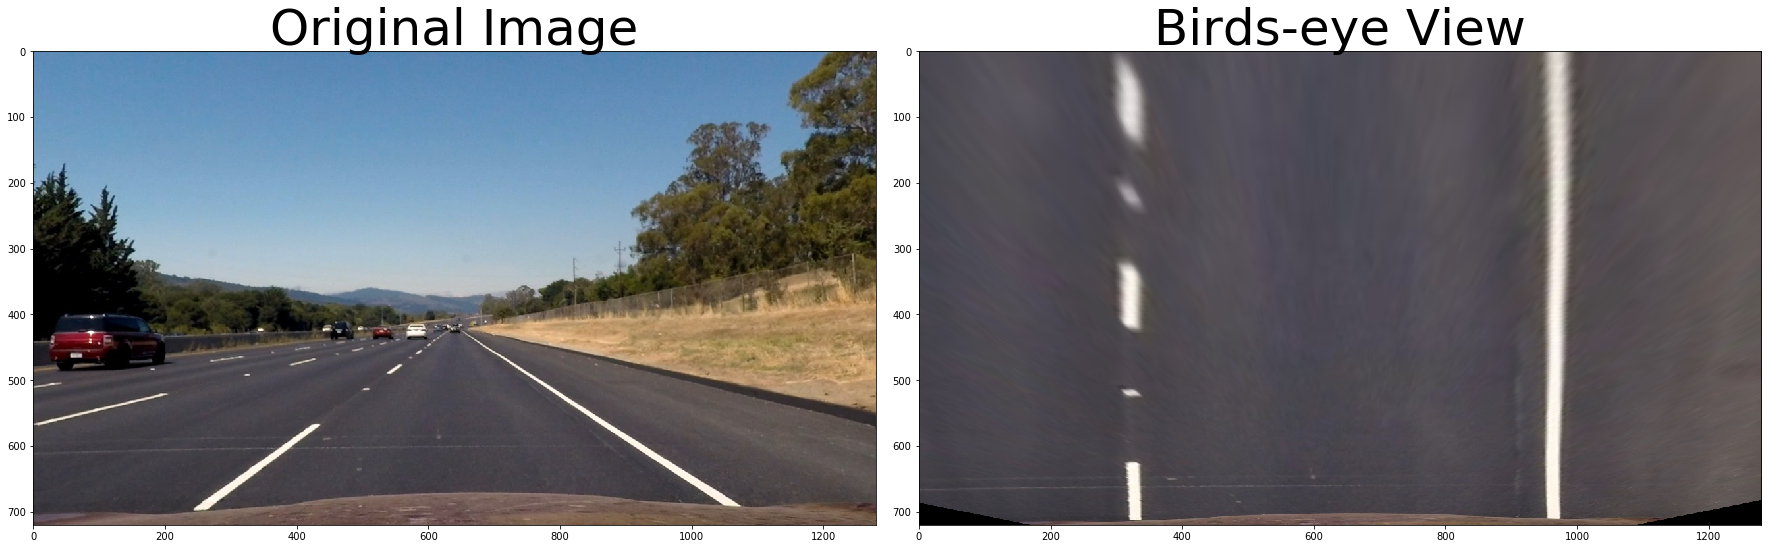

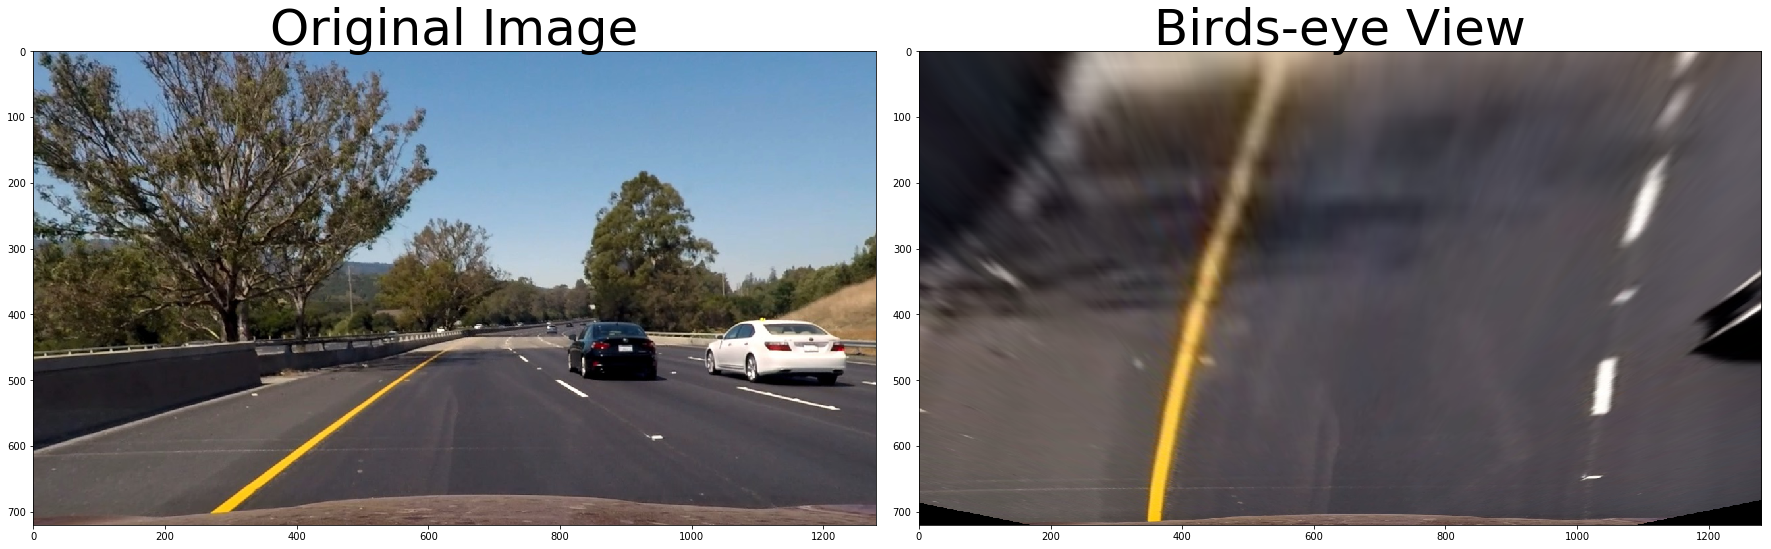

In [10]:
import glob
from pathlib import Path
from itertools import chain

for image_file in chain(glob.glob('test_images/straight_lines*.jpg'),('test_images/test6.jpg',)):
    perspective_example = cv2.undistort(mpimg.imread(image_file), mtx, dist, None, mtx)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

    f.tight_layout()

    ax1.imshow(perspective_example)
    ax1.set_title('Original Image', fontsize=50)
    
    bird_view = bird_eye(perspective_example)
    mpimg.imsave(str(Path('output_birdview') / (Path(image_file).stem + '_birdview.png')), bird_view)
    ax2.imshow(bird_view)
    ax2.set_title('Birds-eye View', fontsize=50)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current+ margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(points_x, points_y, eval_x_at):

    ### Fit a second order polynomial to each using `np.polyfit` ###
    coefficients = np.polyfit(points_y, points_x, 2)

    try:
        x_at = np.polyval(coefficients, eval_x_at)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
    return x_at

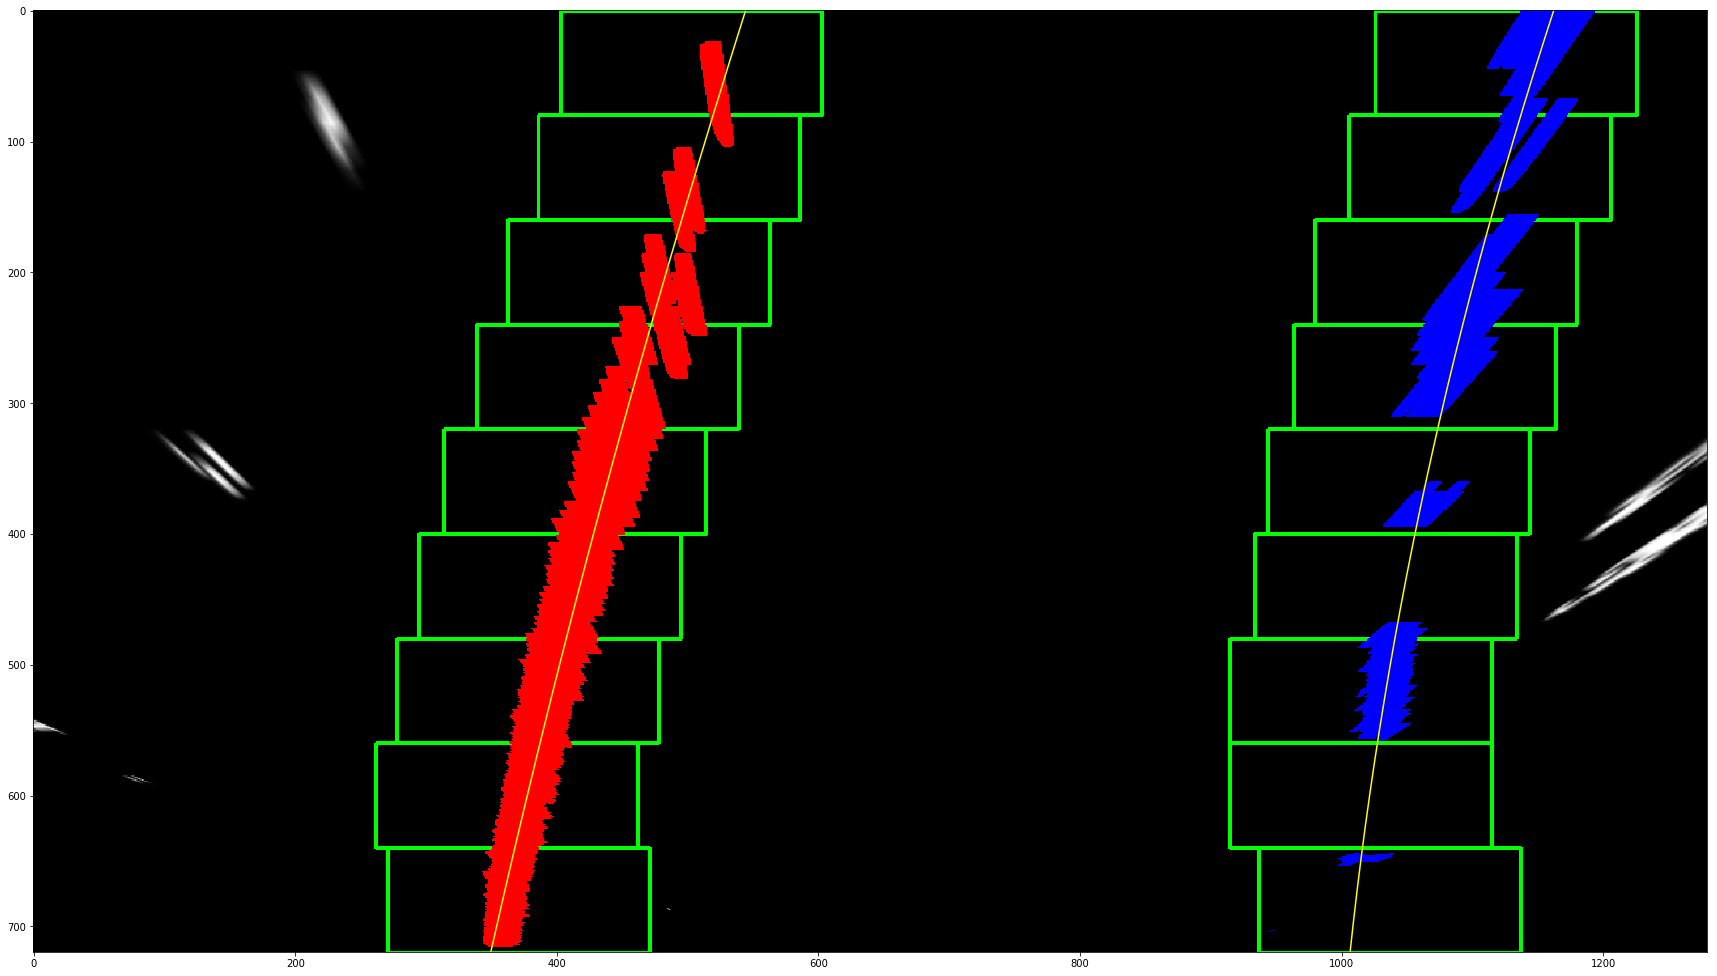

In [12]:
# Load our image
plt.figure(figsize=(30,20))
lane_pxs = pixels_threshold(mpimg.imread('test_images/test6.jpg'))
undist = cv2.undistort(lane_pxs, mtx, dist, None, mtx)
binary_warped = bird_eye(undist)

# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

# Generate x and y values for plotting
ploty = np.array(range(len(binary_warped)))
left_fitx= fit_polynomial(leftx, lefty, ploty)
right_fitx= fit_polynomial(rightx, righty, ploty)

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


plt.imshow(out_img)

## Determine the curvature of the lane and vehicle position with respect to center.

In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 3.0/86 #30/720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 872 *( 640 /(1104-207) ) #3.7/700 # meters per pixel in x dimension
a_to_m_per_pix = xm_per_pix / (ym_per_pix ** 2)
b_to_m_per_pix = xm_per_pix / ym_per_pix
def curvature_at_y(coefficients, y_at):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y = y_at * ym_per_pix
    a = a_to_m_per_pix * coefficients[0]
    b = b_to_m_per_pix * coefficients[1]
    
    return (1 + (2*a*y + b)**2)**1.5/np.abs(2*a)  ## Implement the calculation of the right line here
    

Car offset is 15cm
Left curvature is 572.0 at 719
Right curvature is 385.2 at 719


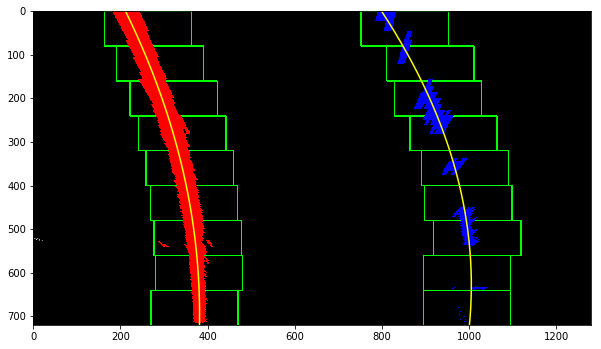

In [14]:
test_image = mpimg.imread('test_images/test2.jpg')
plt.figure(figsize=(10,20))
undist = cv2.undistort(test_image, mtx, dist, None, mtx)
lane_pxs = pixels_threshold(undist)
binary_warped = bird_eye(lane_pxs)
# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

# Generate x and y values for plotting
ploty = np.array(range(len(binary_warped)))

left_weights = 1.0/(len(binary_warped) - lefty)**0.5
left_coefficients = np.polyfit(lefty, leftx, 2, w = left_weights)
left_fitx = np.polyval(left_coefficients, ploty)

right_weights = 1.0/(len(binary_warped) - righty)**0.5
right_coefficients = np.polyfit(righty, rightx, 2, w = right_weights)
right_fitx = np.polyval(right_coefficients, ploty)

print("Car offset is {:.0f}cm".format(100*xm_per_pix*abs(binary_warped.shape[1] - (left_fitx[-1]+right_fitx[-1]))/2.0))
print("Left curvature is {:.1f} at {}".format(curvature_at_y(left_coefficients, ploty[-1]), ploty[-1]))
print("Right curvature is {:.1f} at {}".format(curvature_at_y(right_coefficients,  ploty[-1]),  ploty[-1]))

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


plt.imshow(out_img)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [15]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ()
 
    # Get the RGB buffer from the figure
    h,w = fig.canvas.get_width_height()
    print(h,w)
    buf = np.frombuffer ( fig.canvas.tostring_rgb(), dtype=np.uint8 )
    buf.shape = ( w, h, 3 )
 
    return buf

def fitline_processing_pipeline(image):
    #Image from plot
    fig = plt.figure(figsize=tuple(np.array(np.array(image.shape[-2::-1])/100, dtype=np.int)), dpi = 100, frameon=False )
    ax = fig.gca()
    ax.axis('off')
    fig.tight_layout(pad=0)
    # To remove the huge white borders
    ax.margins(0)
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    lane_pxs = pixels_threshold(undist)
    binary_warped = bird_eye(lane_pxs)
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    if len(leftx) == 0 or len(rightx) == 0:
        return undist        

    # Generate x and y values for plotting
    ploty = np.array(range(len(binary_warped)))

    left_weights = 1.0/(len(binary_warped) - lefty)**0.5
    left_coefficients = np.polyfit(lefty, leftx, 2, w = left_weights)
    left_fitx = np.polyval(left_coefficients, ploty)

    right_weights = 1.0/(len(binary_warped) - righty)**0.5
    right_coefficients = np.polyfit(righty, rightx, 2, w = right_weights)
    right_fitx = np.polyval(right_coefficients, ploty)
        
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)    
    
    full_fig = fig2data(fig)
    plt.clf()
    plt.close(fig)
    
    return full_fig

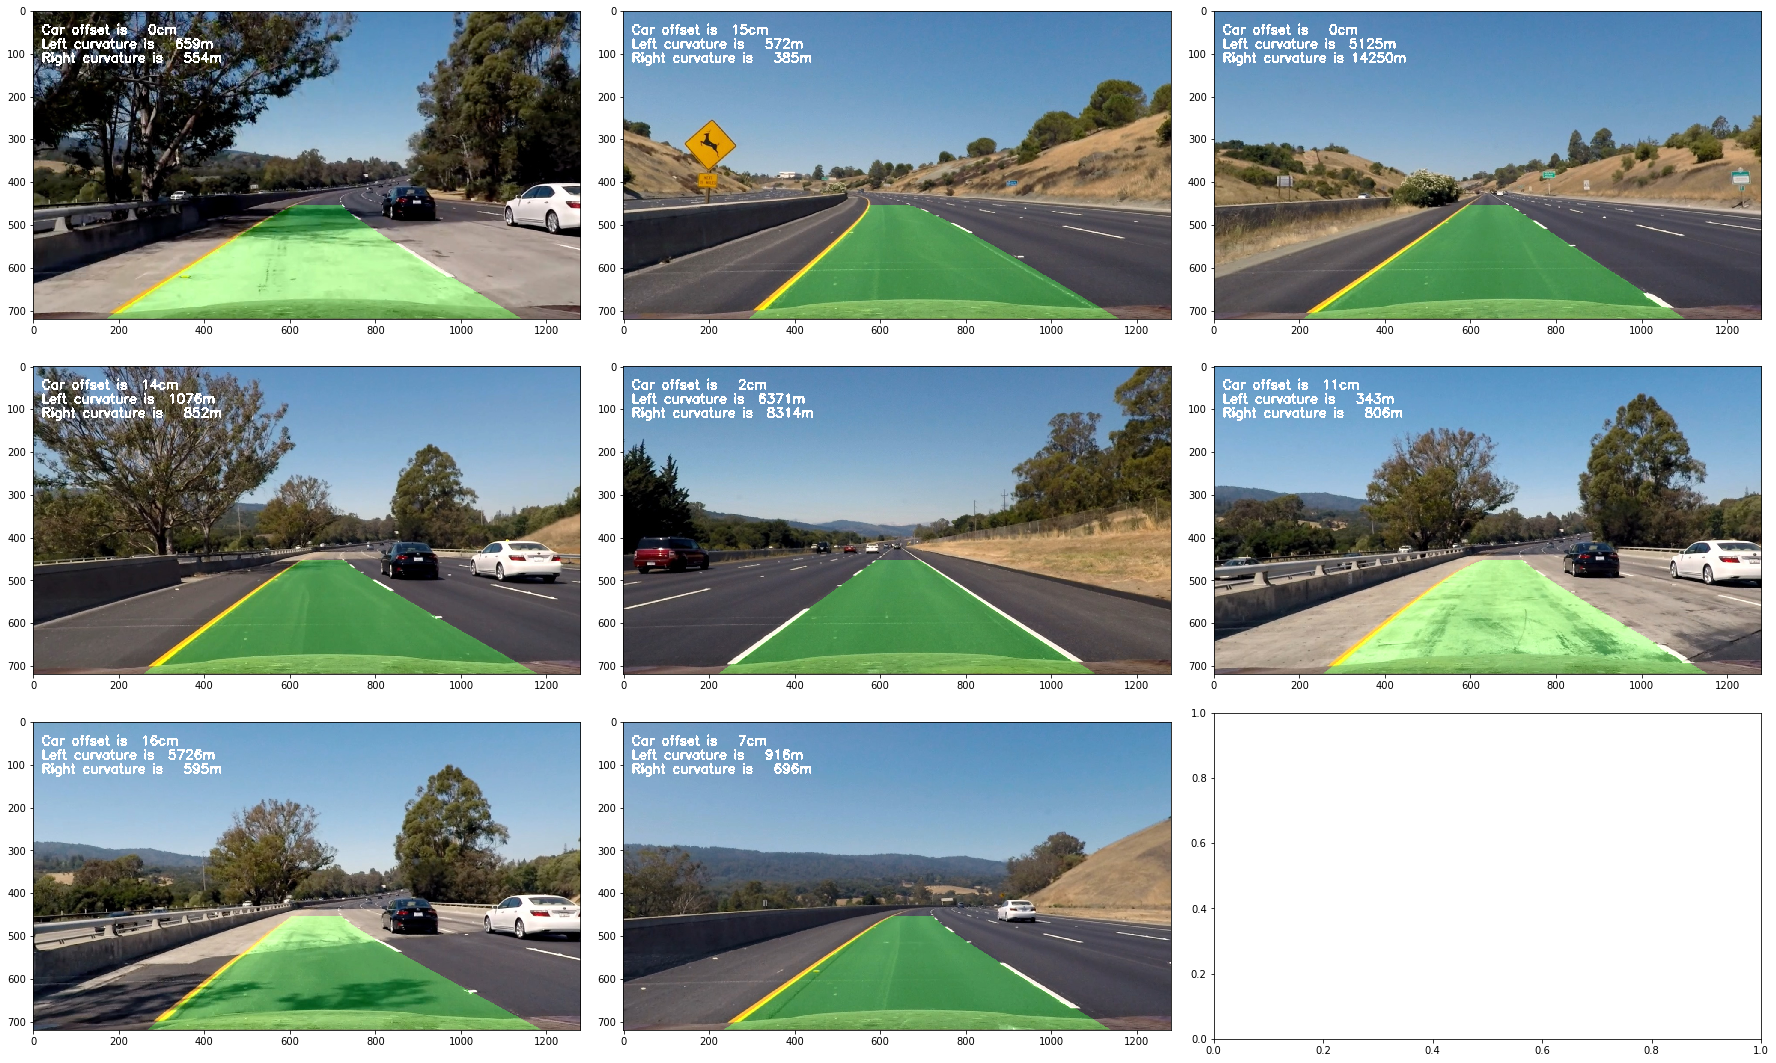

In [16]:
font = cv2.FONT_HERSHEY_SIMPLEX

def image_processing_pipeline(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    lane_pxs = pixels_threshold(undist)
    binary_warped = bird_eye(lane_pxs)
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    if len(leftx) == 0 or len(rightx) == 0:
        return undist        

    # Generate x and y values for plotting
    ploty = np.array(range(len(binary_warped)))

    left_weights = 1.0/(len(binary_warped) - lefty)**0.5
    left_coefficients = np.polyfit(lefty, leftx, 2, w = left_weights)
    left_fitx = np.polyval(left_coefficients, ploty)

    right_weights = 1.0/(len(binary_warped) - righty)**0.5
    right_coefficients = np.polyfit(righty, rightx, 2, w = right_weights)
    right_fitx = np.polyval(right_coefficients, ploty)

    #Create an image to draw the lines on
    color_warp = np.zeros_like(test_image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    infos = (
        "Car offset is {:3.0f}cm".format(100*xm_per_pix*abs(binary_warped.shape[1] - (left_fitx[-1]+right_fitx[-1]))/2.0),
        "Left curvature is {:5.0f}m".format(curvature_at_y(left_coefficients, ploty[-1])),
        "Right curvature is {:5.0f}m".format(curvature_at_y(right_coefficients,  ploty[-1]))
    )
    text_height = 20
    for info in infos:
        (_, height), _ = cv2.getTextSize(info, font, 1, 4)
        text_height += height + 10
        cv2.putText(result, info, (20,text_height), font, 1, (255, 255, 255), 4)
    
    return result

### CellTest

import glob

image_list = list(glob.glob('test_images/*.jpg'))

f, subaxis = plt.subplots((len(image_list)+2)//3, 3, figsize=(24, 16))

f.tight_layout()
for image_file, ax in zip(image_list, subaxis.flatten()):
    ax.imshow(image_processing_pipeline(mpimg.imread(image_file)))

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Video Run

In [17]:
from collections import deque

max_xm_per_frame = 0.1
max_roc_per_frame = 1.0
max_angle_per_frame = 0.1

class ActivatedPixels:
    """Store the activated pixels of an image"""
    def __init__(self, at_x: np.array, at_y: np.array, bounds: tuple):
        self.at_x = at_x
        self.at_y = at_y
        self.bound = dict(zip('xy',bounds))
    
    @staticmethod
    def from_image(binary_image):
        nonzero = binary_image.nonzero()
        return ActivatedPixels(np.array(nonzero[1]), np.array(nonzero[0]), binary_image.shape[1::-1])

# Define a class to receive the characteristics of each line detection
class Lane:
    def __init__(self):
        # number of skipped frames
        self.skiped_frames = 0
        # keep last coefficients to average them out.
        self.recent_coefficients = deque(maxlen=4)
    
    def update_lane_pixels(self, activated_pixels: ActivatedPixels):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 25

        lane_indexs = (np.abs(np.polyval(self.recent_coefficients[-1], activated_pixels.at_y) - activated_pixels.at_x) < margin).nonzero()

        # Again, extract left and right line pixel positions
        lanex = activated_pixels.at_x[lane_indexs]
        laney = activated_pixels.at_y[lane_indexs] 

        # Fit new polynomials
        try:
            # weighting closer point more, the suffer less distortion
            weights = 1.0/(activated_pixels.bound['y'] - laney)**0.5
            coefficients = np.polyfit(laney, lanex, 2, w = weights)
        except TypeError:
            return False
        
        # Sanity checks
        if xm_per_pix * abs(coefficients[2] - self.recent_coefficients[-1][2]) > max_xm_per_frame:
            return False
        
        theta = lambda coef: np.arctan(2*coef[0]*activated_pixels.bound['y'] + coef[1])
        
        if abs(theta(coefficients) - theta(self.recent_coefficients[-1])) > max_angle_per_frame:
            return False
        
        # Uncomment to compare the curvature also
#         new_roc = curvature_at_y(coefficients, y_range[-1])
#         old_roc = curvature_at_y(self.recent_coefficients, y_range[-1])
#         delta_roc = abs(roc_left - roc_right)
#         mean_roc = (roc_left + roc_right)/2.0
#         similar_curvature = delta_roc / mean_roc < max_roc_per_frame
        
        self.recent_coefficients.append(coefficients)
        return True
    
    @staticmethod
    def find_lane_pixels(binary_warped, activated_pixels):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(activated_pixels.bound['y']//nwindows)
        
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin  # Update this
            win_xleft_high = leftx_current + margin  # Update this
            win_xright_low = rightx_current - margin  # Update this
            win_xright_high = rightx_current+ margin  # Update this

            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((activated_pixels.at_y >= win_y_low) & (activated_pixels.at_y < win_y_high) & 
            (activated_pixels.at_x >= win_xleft_low) &  (activated_pixels.at_x < win_xleft_high)).nonzero()[0]
            good_right_inds = ((activated_pixels.at_y >= win_y_low) & (activated_pixels.at_y < win_y_high) & 
            (activated_pixels.at_x >= win_xright_low) &  (activated_pixels.at_x < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(activated_pixels.at_x[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(activated_pixels.at_x[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = activated_pixels.at_x[left_lane_inds]
        lefty = activated_pixels.at_y[left_lane_inds] 
        rightx = activated_pixels.at_x[right_lane_inds]
        righty = activated_pixels.at_y[right_lane_inds]
        
        try:
            left_coefficients = np.polyfit(lefty, leftx, 2)
        except TypeError:
            left_coefficients = None
        try:
            right_coefficients = np.polyfit(righty, rightx, 2)
        except TypeError:
            right_coefficients = None

        return left_coefficients, right_coefficients

In [18]:
max_skiped_frames = 6
lane_distance = 3
max_delta_lane = 5
min_delta_lane = 1
max_roc_difference = 1.0
font = cv2.FONT_HERSHEY_SIMPLEX

class LaneTraker:
    def __init__(self):
        self.lanes = {'left': Lane(), 'right': Lane()}
        self.lanes['left'].skiped_frames = max_skiped_frames + 1
        self.lanes['right'].skiped_frames = max_skiped_frames + 1
        
    def process_video_frame(self, frame):
        ## Pre-processing
        undist = cv2.undistort(frame, mtx, dist, None, mtx)
        lane_pxs = pixels_threshold(undist)
        binary_warped = bird_eye(lane_pxs)
        activated_pixels = ActivatedPixels.from_image(binary_warped)

        # Find our lane pixels first
        y_range = np.array(range(len(binary_warped)))
        
        # Find lanes (window method) it skipped too many frames
        if any(lane.skiped_frames > max_skiped_frames for lane in self.lanes.values()):
            left_coefficients, right_coefficients = Lane.find_lane_pixels(binary_warped, activated_pixels)
            
            visible_lanes = left_coefficients is not None and right_coefficients is not None
            
            # Sanity checks
            if visible_lanes:
                roc_left = curvature_at_y(left_coefficients, y_range[-1])
                roc_right = curvature_at_y(right_coefficients, y_range[-1])
                delta_roc = abs(roc_left - roc_right)
                mean_roc = (roc_left + roc_right)/2.0
                similar_curvature = (delta_roc - lane_distance) / mean_roc < max_roc_difference

                road_separated = min_delta_lane < xm_per_pix * abs(left_coefficients[-1] - right_coefficients[-1]) < max_delta_lane

                if similar_curvature and road_separated:
                    self.lanes['left'].recent_coefficients.append(left_coefficients)
                    self.lanes['right'].recent_coefficients.append(right_coefficients)

                    self.lanes['left'].skiped_frames = 0
                    self.lanes['right'].skiped_frames = 0
                    
        else:
            # Try to update lanes (find new one around the old one)
            for lane in self.lanes.values():
                if not lane.update_lane_pixels(activated_pixels):
                    lane.skiped_frames += 1
                else:
                    lane.skiped_frames = 0
            
        # Just return undistorted image until both lanes are found on a image.
        if any(len(lane.recent_coefficients) == 0 for lane in self.lanes.values()):
            return undist
        
        # Average recent coefficients to smooth
        left_coefficients = np.mean(self.lanes['left'].recent_coefficients, axis=0)
        right_coefficients = np.mean(self.lanes['right'].recent_coefficients, axis=0)
        left_fitx = np.polyval(left_coefficients, y_range)
        right_fitx = np.polyval(right_coefficients, y_range)
            

        #Create an image to draw the lines on
        color_warp = np.zeros_like(frame).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, y_range]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_range])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        infos = (
            "Car offset is {:3.0f}cm".format(100*xm_per_pix*abs(binary_warped.shape[1] - (left_fitx[-1]+right_fitx[-1]))/2.0),
            "Left curvature is {:5.0f}m".format(curvature_at_y(left_coefficients, y_range[-1])),
            "Right curvature is {:5.0f}m".format(curvature_at_y(right_coefficients,  y_range[-1]))
        )
        text_height = 20
        for info in infos:
            (_, height), _ = cv2.getTextSize(info, font, 1, 4)
            text_height += height + 10
            cv2.putText(result, info, (20,text_height), font, 1, (255, 255, 255), 4)

        return result

In [19]:
def draw_visualization(binary_warped):    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0237568/28549024 bytes (0.8663552/28549024 bytes (2.31155072/28549024 bytes (4.0%1744896/28549024 bytes (6.1%2039808/28549024 bytes (7.1%2187264/28549024 bytes (7.7%2301952/28549024 bytes (8.1%2465792/28549024 bytes (8.6%2596864/28549024 bytes (9.1%2695168/28549024 bytes (9.4%2809856/28549024 bytes (9.8%2924544/28549024 bytes (10.23072000/28549024 bytes (10.83227648/28549024 bytes (11.33350528/28549024 bytes (11.73465216/28549024 bytes (12.13579904/28549024 bytes (12.53694592/28549024 bytes (12.93809280/28549024 bytes (13.33923968/28549024 bytes (13.74055040/28549024 bytes (14.24202496/28549024 bytes (14.74333568/28549024 bytes (15.24448256/28549024 bytes (15.64579328/28549024 bytes (16.04694016/28549024 bytes (16.44808704/28549024 bytes (16.84931584/28549024 bytes (1

In [23]:
white_output = 'output_videos/filtered_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
tracker = LaneTraker()
white_clip = clip1.fl_image(tracker.process_video_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/filtered_project_video.mp4
[MoviePy] Writing video output_videos/filtered_project_video.mp4


100%|█████████▉| 1260/1261 [03:53<00:00,  5.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/filtered_project_video.mp4 

CPU times: user 5min 56s, sys: 45.7 s, total: 6min 42s
Wall time: 3min 54s
